# Geospatial data analysis thermal springs

This notebook reads the thermal spring dataset, gets rid of well data and springs outside of the alps, and calculates spatial statistics using external datasets such as groundwater recharge, surface lithology, proximity to faults, etc... 

The results are saved as a new csv file that can then be used by other notebooks for additional analysis

**Input:** ``data/thermal_springs_alps.csv`` -> spring dataset. This can be obtained by saving the second sheet of the google drive database as a comma separated file.

**Output:** input filename with ``'_with_geospatial_data.csv`` appended to it -> contains additional columns that contain recharge, elevation and lithology data from the raster datafile that you can specify below. 

Note that this notebook also cleans the thermal spring dataset by removing all areas that are outside the alps. The outline of the Alps can be defined by a polygon shapefile, see ``GIS_data/outline_alps_final.shp``

In [1]:
import math
import itertools
import string
import random
import os
import chardet


import numpy as np
import pandas as pd
import geopandas as gp
import rasterio as rio

from rasterstats import zonal_stats

#import shapely.geometry as gm
import matplotlib.pyplot as pl

import shapely.geometry

#import lib.pyGISlib as pyGISlib

In [2]:
import osgeo.osr
import osgeo.gdal

def read_raster_file(filename, verbose=False, band_number=1):
    """
    Read gdal-compatible raster file and convert to numpy array
    
    Parameters
    ----------
    filename : string
        filename of gdal compatible raster file
    verbose : bool, optional
        verbose output
    
    Returns
    -------
    raster_array : array
        raster data
    dimensions : list
        x and y size of raster
    origin : list 
        coordinates of (0,0) point of raster
    cellsize : list
        cellsize of raster
    nodata : float
        nodata value
    projection : osgeo.osr.SpatialReference class

    """

    if os.path.isfile(filename):
        raster = osgeo.gdal.Open(filename, osgeo.gdal.GA_ReadOnly)
    else:
        print('error, could not open file %s' % filename)
        return None, None, None, None, None, None

    if verbose is True:
        print('\tnumber of raster bands:', raster.RasterCount)

    inband = raster.GetRasterBand(band_number)
    geotransform = raster.GetGeoTransform()
    dimensions = [inband.XSize, inband.YSize]
    nodata = inband.GetNoDataValue()
    origin = [geotransform[0], geotransform[3]]
    cellsize = [geotransform[1], geotransform[5]]
    projection = osgeo.osr.SpatialReference()
    projection.ImportFromWkt(raster.GetProjectionRef())

    if verbose is True:
        print('\torigin = (', geotransform[0], ',', geotransform[3], ')')
        print('\tpixel Size = (', geotransform[1], ',', geotransform[5], ')')
        print('\tdimensions: x= %s, y= %s' % (inband.XSize, inband.YSize))
        print('\tstart reading raster file')

    raster_array = raster.ReadAsArray()

    if verbose is True:
        print('\tfinished reading raster file')
        print('min,max data values = %0.1f - %0.1f' \
              % (raster_array.min(), raster_array.max()))

    return raster_array, dimensions, origin, cellsize, nodata, projection



## Define a function that we'll need later on:

In [3]:
def haversine(lon1, lat1, lon2, lat2):

    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles

    return c * r

## Define GIS files to use:

note, the elevation raster should always be last

In [4]:
spring_data_file = 'data/thermal_springs_alps.csv'

recharge_raster = 'GIS_data/rch_mod.tif'
lithology_raster = 'GIS_data/GLIM_WGS84_xx_001deg1_alps.tif'
waterlevel_depth_raster = 'GIS_data/gw_lvl_depth.tif'
waterlevel_elevation_raster = 'GIS_data/gw_lvl_elevation.tif'
surface_temp_raster = 'GIS_data/long_term_mean_annual_temp.tif'
dem_file = 'GIS_data/gmted2010_alps_ll.tif'

raster_files = [recharge_raster, lithology_raster, waterlevel_depth_raster, waterlevel_elevation_raster, surface_temp_raster, dem_file]

process_zonal_stats = [True, False, True, True,  True, True]

variable_names = ['recharge', 'lithology', 'gw_lvl_depth', 'gw_lvl_elev', 'surface_temp', 'elevation', ]

fnb = 'GIS_data/outline_alps_final.shp'

alps_bnd_buffer = 0.01

## Load the thermal springs csv file:

In [5]:
def find_encoding(fname):
    r_file = open(fname, 'rb').read()
    result = chardet.detect(r_file)
    charenc = result['encoding']
    return charenc


encoding = find_encoding(spring_data_file)
print(encoding)

UTF-8-SIG


In [6]:
df = pd.read_csv(spring_data_file, dtype={'reference': object, 'reference_link': object}, encoding=encoding)
print('columns in csv file: ', df.columns.tolist())
df.head()

columns in csv file:  ['spring number', 'spring location', 'spring name', 'long', 'lat', 'type', 'well_depth', 'flow_rate_mean', 'flow_rate_min', 'flow_rate_max', 'temp_mean', 'temp_min', 'temp_max', 'reference', 'reference_DOI', 'reference_link', 'EC', 'pH', 'sample_temperature', 'TDS', 'TDS_min', 'TDS_max', 'Na', 'Ca', 'Mg', 'K', 'NH4', 'Cl', 'F', 'SO4', 'HCO3', 'CO3', 'NO3', 'Si', 'Li', 'SiO2', 'reference_hydrochemistry', 'doi_hydrochemistry', 'reference_link_hydrochemistry', 'delta_18O', 'delta_2H', '3H', 'delta_14C', 'delta_13C', '4He', '3He', 'reference_isotope_data', 'DOI_isotope_data', 'reference_link_isotope_data']


,spring number,spring location,spring name,long,lat,type,well_depth,flow_rate_mean,flow_rate_min,flow_rate_max,...,delta_18O,delta_2H,3H,delta_14C,delta_13C,4He,3He,reference_isotope_data,DOI_isotope_data,reference_link_isotope_data
0,1,Euganei (Euganean geothermal area - Abano Terme,Bonato 1,11.787467,45.344444,well,269,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Euganei (Euganean geothermal area - Abano Terme,All' Alba,11.787467,45.344444,well,NaN,NaN,NaN,NaN,...,-11.0,-83.1,NaN,NaN,NaN,NaN,NaN,Gherardi F. et al. (2000): Water and gas geoch...,https://doi.org/10.1016/S0883-2927(99)00056-6,https://www.researchgate.net/publication/24221...
2,3,Euganei (Euganean geothermal area - Abano Terme,Toson,11.787467,45.344444,well,602,NaN,NaN,NaN,...,-10.1,-71.5,NaN,NaN,NaN,NaN,NaN,Gherardi F. et al. (2000): Water and gas geoch...,https://doi.org/10.1016/S0883-2927(99)00056-6,https://www.researchgate.net/publication/24221...
3,4,Euganei (Euganean geothermal area - Abano Terme,Bernabei,11.787467,45.344444,well,NaN,NaN,NaN,NaN,...,-11.0,-82.1,NaN,NaN,NaN,NaN,NaN,Gherardi F. et al. (2000): Water and gas geoch...,https://doi.org/10.1016/S0883-2927(99)00056-6,https://www.researchgate.net/publication/24221...
4,5,Euganei (Euganean geothermal area - Abano Terme,Espana,11.787467,45.344444,well,NaN,NaN,NaN,NaN,...,-10.2,-72.0,NaN,NaN,NaN,NaN,NaN,Gherardi F. et al. (2000): Water and gas geoch...,https://doi.org/10.1016/S0883-2927(99)00056-6,https://www.researchgate.net/publication/24221...


## Convert to numeric data and remove wells, boreholes and tunnels:

In [7]:
# make all data numeric
for col in df.columns:
    if 'spring' not in col and 'type' not in col:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        df[col] = df[col]

# remove empty lines
df = df.dropna(subset=['spring location'])
df = df.dropna(subset=['lat', 'long'])
df = df.loc[df['lat'].notnull()]

ind = df['flow_rate_mean'] == 0.0
df = df.loc[ind==False]

# remove wells
well_depth_cutoff = 100.0
ind = (df['type'] == 'well') & (df['well_depth'] > well_depth_cutoff)
df = df.loc[ind==False]
ind = (df['type'] == 'borehole') & (df['well_depth'] > well_depth_cutoff)
df = df.loc[ind==False]
ind = (df['type'] == 'well') & (df['well_depth'].isnull())
df = df.loc[ind==False]
ind = (df['type'] == 'borehole') & (df['well_depth'].isnull())
df = df.loc[ind==False]

ind = (df['type'] == 'tunnel') | (df['type'] == 'gallery')
df = df.loc[ind==False]

ind = df['type'] == 'unknown'
df = df.loc[ind==False]

df = df.dropna(subset=['type'])

print('number of springs left = %i' % len(df))

number of springs left = 576


In [8]:
print('type of springs: ', df['type'].unique())

ind = (df['type'] == 'well') | (df['type'] == 'borehole')
print('well depths:\n', df.loc[ind, 'well_depth'].describe())

type of springs:  ['spring' 'springs and shallow wells' 'spring or shallow well' 'well'
 'gallery & borehole' 'borehole' 'spring ']
well depths:
 count     90.000000
mean      31.723556
std       30.757808
min        2.000000
25%        7.262500
50%       15.500000
75%       52.825000
max      100.000000
Name: well_depth, dtype: float64


## Calculate mean temperature and flow rate for springs with only min. and max. values available:

In [9]:
# calculate mean temperature for datapoints with min, max T only
df['temperature'] = df['temp_mean']
ind = df['temperature'].isnull()
df.loc[ind, 'temperature'] = 0.5 * df.loc[ind, 'temp_min'] + 0.5 * df.loc[ind, 'temp_max']

# calculate mean flow rate from min and max 
df['flow_rate'] = df['flow_rate_mean']
ind = df['flow_rate'].isnull()
df.loc[ind, 'flow_rate'] = 0.5 * df.loc[ind, 'flow_rate_min'] + 0.5 * df.loc[ind, 'flow_rate_max']

# calculate log flow rate & temperature 
df['log_flow_rate'] = np.log10(df['flow_rate'])
df['log_temperature'] = np.log10(df['temperature'])

df = df.replace([-np.inf, np.inf], np.nan)

print('number of remaining springs = %i' % (len(df)))

number of remaining springs = 576


## convert spring dataset to geopandas file:

(code found here https://gis.stackexchange.com/questions/114066/handling-kml-csv-with-geopandas-drivererror-unsupported-driver-ucsv)

In [10]:
df['geometry'] = df.apply(lambda z: shapely.geometry.Point(z['long'], z['lat']), axis=1)
dg = gp.GeoDataFrame(df)
#dg = dg.astype({'reference': str})

## Read shapefile with boundary Alps

In [11]:
dgb = gp.read_file(fnb)
alps_poly = dgb.buffer(alps_bnd_buffer).geometry[0]

## Generate a collection of random points for comparing geospatial statistics:

In [12]:
# number of random points
n_target = len(df)

(minx, miny, maxx, maxy) = alps_poly.bounds

n = 0
dr = gp.GeoDataFrame(index=np.arange(n_target), columns=['lat', 'long'])

random_pts = []
while n < n_target:
    long = random.uniform(minx, maxx)
    lat = random.uniform(miny, maxy)
    p = shapely.geometry.Point(long, lat)
    if p.within(alps_poly):
        random_pts.append(p)
        dr.loc[n]['lat'] = lat
        dr.loc[n]['long'] = long
        n += 1

dr.geometry = random_pts

## combine geodataframes in list:

In [13]:
dgs = [dg, dr]

## remove points that are not within the Alps shapefile

number of springs in the alps + buffer of 0.01 degrees = 394


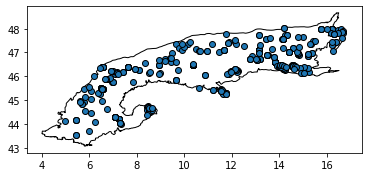

In [14]:
for i, dgi in enumerate(dgs):
    #dg['in_alps'] = dg.within(alps_poly)
    dgs[i] = dgi.loc[dgi.geometry.within(alps_poly)]
    #dgc = dg.loc[dg['in_alps']]

fig, ax = pl.subplots(1, 1)
dgb.plot(ax=ax, facecolor='None', edgecolor='black')
#dr.plot(ax=ax, color='red')
dgs[0].plot(ax=ax, edgecolor='black')

print('number of springs in the alps + buffer of %0.2f degrees = %i' % (alps_bnd_buffer, len(dgs[0])))

## Load raster data for the springs and the random points

In [15]:
print('finding raster data values at spring locations')

dgs_final = []
for dgi in dgs: 
    for raster_file, variable_name in zip(raster_files, variable_names):
        
        print(raster_file, variable_name)
        
        dgi[variable_name] = np.nan
        
        #raster_array, dimensions, origin, cellsize, nodata, projection = \
        #    pyGISlib.read_raster_file(raster_file)
        raster_array, dimensions, origin, cellsize, nodata, projection = read_raster_file(raster_file)

        # go through all springs
        xps, yps = dgi['long'].values, dgi['lat'].values
        xps, yps = xps.astype(float), yps.astype(float)
        xgs = (np.round((xps - (origin[0] + cellsize[0] * 0.5)) / cellsize[0])).astype(int)
        ygs = (np.round((yps - (origin[1] + cellsize[1] * 0.5)) / cellsize[1])).astype(int)

        for ix, xpi, ypi in zip(dgi.index, dgi['long'], dgi['lat']):

            if np.isnan(xpi) == False and np.isnan(ypi) == False:
                xg = np.int(np.round((xpi - (origin[0] + cellsize[0] * 0.5)) / cellsize[0]))
                yg = np.int(np.round((ypi - (origin[1] + cellsize[1] * 0.5)) / cellsize[1]))

                if xg > 0 and yg > 0 and xg < raster_array.shape[1] and yg < raster_array.shape[0]:
                    dgi.loc[ix, variable_name] = raster_array[yg, xg]
                else:
                    print('warning, the following spring has a location that is outside the bound of %s the raster: %s' 
                          % (variable_name, str(df.loc[ix])))
        # convert nodata values to nan
        dgi.loc[dgi[variable_name] == nodata, variable_name] = np.nan
    
    dgs_final.append(dgi)

finding raster data values at spring locations
GIS_data/rch_mod.tif recharge


/Users/elcopone/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/elcopone/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


GIS_data/GLIM_WGS84_xx_001deg1_alps.tif lithology
GIS_data/gw_lvl_depth.tif gw_lvl_depth
GIS_data/gw_lvl_elevation.tif gw_lvl_elev
GIS_data/long_term_mean_annual_temp.tif surface_temp
GIS_data/gmted2010_alps_ll.tif elevation
GIS_data/rch_mod.tif recharge
GIS_data/GLIM_WGS84_xx_001deg1_alps.tif lithology
GIS_data/gw_lvl_depth.tif gw_lvl_depth
GIS_data/gw_lvl_elevation.tif gw_lvl_elev
GIS_data/long_term_mean_annual_temp.tif surface_temp
GIS_data/gmted2010_alps_ll.tif elevation


## Calculate contributing area

In [16]:
dg = dgs_final[0]

In [17]:
year = 365.25 * 24 * 3600
dg['contributing_area'] = dg['flow_rate_mean'] / (dg['recharge'] / year)

print('flow rate (m s-1):\n', dg['flow_rate_mean'].describe())

print('contributing area (m2):\n', dg['contributing_area'].describe())

dg['log_contrib_area'] = np.log10(dg['contributing_area'])
dg['log_contrib_area'] = dg['log_contrib_area'].replace([np.inf, -np.inf], np.nan)

flow rate (m s-1):
 count    225.000000
mean       0.009387
std        0.028127
min        0.000001
25%        0.000300
50%        0.001500
75%        0.005029
max        0.220000
Name: flow_rate_mean, dtype: float64
contributing area (m2):
 count    2.250000e+02
mean     6.129354e+05
std      1.871053e+06
min      1.468059e+02
25%      1.851829e+04
50%      7.262816e+04
75%      3.877195e+05
max      1.590481e+07
Name: contributing_area, dtype: float64


## Create a circular buffer around each spring that is equal to the contributing area

convert the circle radius to degrees using the haversine formula

note for now this only calculates the average distance of one degree and uses this to convert the radius from meters to degrees. This is not so exact, but probably not too bad

In [18]:
record_relief_in_contrib_area = False

if record_relief_in_contrib_area is True:

    dg['circle_radius'] = np.sqrt(dg['contributing_area'] / np.pi) * 4.0

    print('radius of contributing area around each spring (m):\n', dg['circle_radius'].describe())

    long_avg = dg['long'].mean()
    lat_avg = dg['lat'].mean()
    dlong = haversine(long_avg, lat_avg, long_avg + 1, lat_avg)
    dlat = haversine(long_avg, lat_avg, long_avg, lat_avg + 1.0)
    davg = (dlong + dlat) / 2.0

    dg['circle_radius_degrees'] = dg['circle_radius'] / davg / 1000.0
    dg['circle_radius_degrees_long'] = dg['circle_radius'] / dlong / 1000.0
    dg['circle_radius_degrees_lat'] = dg['circle_radius'] / dlat / 1000.0

## Record the min, mean and max elevation in each circular buffer:

In [19]:

if record_relief_in_contrib_area is True:
    print('finding elevation within contributing area (this may take a while....)')

    # get coordinates of raster points elevation raster (assuming this was the last 
    # raster that was loaded)
    xi = (np.arange(dimensions[0]) + 0.5) * cellsize[0] + origin[0]
    yi = (np.arange(dimensions[1]) + 0.5) * cellsize[1] + origin[1]
    xgr , ygr = np.meshgrid(xi, yi)

    # go through all springs
    for i, ix, xpi, ypi, crx, cry in zip(itertools.count(), dg.index, dg['long'], dg['lat'], 
                                         dg['circle_radius_degrees_long'], 
                                         dg['circle_radius_degrees_lat']):

        if int(i / 50.0) == float(i / 50.0):
            print('thermal spring %i of %i' % (i, len(dg)))

        if np.isnan(xpi) == False and np.isnan(ypi) == False and np.isnan(crx) == False:
            #xg = int(np.round((xpi - (origin[0] + cellsize[0] * 0.5)) / cellsize[0]))
            #yg = int(np.round((ypi - (origin[1] + cellsize[1] * 0.5)) / cellsize[1]))
            #ind = (xgr >= (xpi - crx)) & (xgr <= (xpi + crx)) & (ygr >= (ypi - cry)) & (ygr <= (ypi + cry))


            # find the edges of the circle in the 2d array
            x1 = int(np.floor(((xpi - crx) - origin[0]) / cellsize[0])) 
            x2 = int(np.ceil(((xpi + crx) - origin[0]) / cellsize[0])) 
            y2 = int(np.floor(((ypi - cry) - origin[1]) / cellsize[1])) 
            y1 = int(np.ceil(((ypi + cry) - origin[1]) / cellsize[1])) 

            # select the square/region in array where circle is located
            xgrs = xgr[y1:y2+1, x1:x2+1]
            ygrs = ygr[y1:y2+1, x1:x2+1]
            zs = raster_array[y1:y2+1, x1:x2+1]

            # calculate distance of each ratser point to the thermal spring, normalized to the size of the contributing area
            dxn = (xgrs - xpi) / crx
            dyn = (ygrs - ypi) / cry
            #dr = np.sqrt((xgr - xpi) ** 2 + (ygr - ypi)**2)
            #ind = dr <= cr
            dr = np.sqrt(dxn**2 + dyn**2) 

            # select parts of elevation raster that are within the contributing area
            ind = dr <= 1.0
            ds = zs[ind]

            # 
            if np.any(ind) == True:
                dg.loc[ix, 'elevation_buffer_min'] = ds.min()
                dg.loc[ix, 'elevation_buffer_max'] = ds.max()
                dg.loc[ix, 'elevation_buffer_mean'] = ds.mean()
                dg.loc[ix, 'elevation_buffer_median'] = np.median(ds)
                dg.loc[ix, 'found_buffer_elevation'] = True
            else:
                dg.loc[ix, 'found_buffer_elevation'] = False
        #print(bla)

## Find watershed where each spring is located in

### Load watershed shapefile

In [20]:
# load watershed file
fnw = 'GIS_data/eu_pfaf_gamma.shp'

dgw = gp.read_file(fnw)

dgw.head()

,BASIN_ID,NEXT_DN,MAIN_BAS,UP_AREA,SUB_AREA,DIST_DN,PFAF_1,PFAF_2,PFAF_3,PFAF_4,PFAF_5,PFAF_6,PFAF_7,PFAF_8,PFAF_9,PFAF_10,PFAF_11,PFAF_12,PFAF_13,geometry
0,2000001,0,2000001,5.1,5.1,0.0,2,21,211,2110,21101,211011,2110110,21101100,211011000,2110110000,21101100000,211011000000,2110110000000,"POLYGON ((32.32083 31.26667, 32.27500 31.26667..."
1,2000002,0,2000002,6264.1,157.7,0.0,2,21,211,2110,21101,211012,2110120,21101201,211012010,2110120101,21101201011,211012010110,2110120101100,"POLYGON ((32.22500 30.97500, 32.22689 30.98144..."
2,2000003,0,2000003,5.0,5.0,0.0,2,21,211,2110,21101,211013,2110130,21101301,211013010,2110130101,21101301010,211013010100,2110130101000,"POLYGON ((32.32083 31.24583, 32.31842 31.26053..."
3,2000004,0,2000004,113.3,113.3,0.0,2,21,211,2110,21101,211013,2110130,21101301,211013010,2110130102,21101301020,211013010200,2110130102000,"POLYGON ((32.34583 31.08750, 32.33828 31.08966..."
4,2000005,0,2000005,49.6,49.6,0.0,2,21,211,2110,21101,211013,2110130,21101301,211013010,2110130103,21101301030,211013010300,2110130103000,"POLYGON ((32.50417 31.10833, 32.50174 31.11007..."


### Crop the shapefile

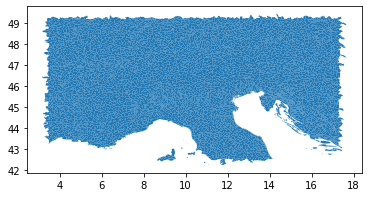

In [21]:
buffer = 0.5
xmin, ymin, xmax, ymax = alps_poly.bounds

xmin -= buffer
xmax += buffer
ymin -= buffer
ymax += buffer

dgw = dgw.cx[xmin:xmax, ymin:ymax]
dgw.plot()

### Go through springs and find watershed

In [22]:
for i, dgi in enumerate(dgs_final):
    dgi['geometry_ws'] = dgi['geometry'].copy()
    dgi['watershed_area'] = np.nan
    for j, wsid in enumerate(dgi.index):
        if int(j/100) == float(j/100.0):
            print('finding watershed for spring %i of %i' % (j, len(dgi)))
        if dgi.loc[wsid].geometry is not None:
            ws_ind = dgw.contains(dgi.loc[wsid].geometry)

            if np.any(ws_ind.values):
                ws_ind2 = dgw.loc[ws_ind].index[0]
                #ws_poly = dgw.loc[ws_ind].dissolve(by='BASIN_ID')

                # see issue reported here: https://github.com/pandas-dev/pandas/issues/26333
                a = dgw.loc[[ws_ind2]].geometry.values[0]

                dgi.loc[[wsid], 'geometry_ws'] = dgw.loc[[ws_ind2], 'geometry'].values
                dgi.loc[[wsid], 'watershed_area'] = dgw.loc[[ws_ind2], 'SUB_AREA'].values[0] * 1e6
            else:
                dgi.loc[[wsid], 'geometry_ws'] = np.nan

    # copy back modified watershed file into list
    dgs_final[i] = dgi

finding watershed for spring 0 of 394
finding watershed for spring 100 of 394
finding watershed for spring 200 of 394
finding watershed for spring 300 of 394
finding watershed for spring 0 of 576
finding watershed for spring 100 of 576
finding watershed for spring 200 of 576
finding watershed for spring 300 of 576
finding watershed for spring 400 of 576
finding watershed for spring 500 of 576


## Process zonal stats in watersheds

In [23]:
print('processing zonal statistics watershed areas')

rasters_zs = [r for r, yn in zip(raster_files, process_zonal_stats) if yn is True]
var_names_zs = [v for v, yn in zip(variable_names, process_zonal_stats) if yn is True]
                                   
for raster, var_name in zip(rasters_zs, var_names_zs):
    
    print(raster, var_name)                               
                                   
    raster = rio.open(raster)
    zr = raster.read(1)
    
    #affine = raster.transform
    # alternative for rasterio pre version 1.0:
    affine = raster.affine
    
    zs_cols = ['mean_%s_ws' % var_name, 'min_%s_ws'  % var_name, 'max_%s_ws'  % var_name]
    stats =['mean', 'min', 'max']

    print('going through spring data')
    print('and saving in columns %s' % zs_cols)
    for i, dgi in enumerate(dgs_final):
        
        for zs_col in zs_cols:
            dgi[zs_col] = np.nan
        #dgi['min_elevation_ws'] = np.nan
        #dgi['max_elevation_ws'] = np.nan
        #dgi['mean_elevation_ws'] = np.nan

        for j, springid in enumerate(dgi.index):
            if int(j/100) == float(j/100.0):
                print('finding %s stats for spring %i of %i' % (var_name, j, len(dgi)))
                

            #try:
            if dgi.loc[springid, 'geometry_ws'] is not None:
                zs = zonal_stats(dgi.loc[springid, 'geometry_ws'], 
                                 zr, affine=affine, stats=stats)

                dgi.loc[springid, zs_cols[0]] = zs[0][stats[0]]
                dgi.loc[springid, zs_cols[1]] = zs[0][stats[1]]
                dgi.loc[springid, zs_cols[2]] = zs[0][stats[2]]

            #except:
                #print('failed to find zonal stats for spring ',j, springid)
            #    pass
            
        # copy back modified watershed file into list
        dgs_final[i] = dgi
    
#
for i, dgi in enumerate(dgs_final):
    # calculate relief
    dgs_final[i]['ws_relief'] = dgs[i]['max_elevation_ws'] - dgs[i]['min_elevation_ws']

processing zonal statistics watershed areas
GIS_data/rch_mod.tif recharge
going through spring data
and saving in columns ['mean_recharge_ws', 'min_recharge_ws', 'max_recharge_ws']
finding recharge stats for spring 0 of 394


/Users/elcopone/opt/miniconda3/lib/python3.7/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


finding recharge stats for spring 100 of 394
finding recharge stats for spring 200 of 394
finding recharge stats for spring 300 of 394
finding recharge stats for spring 0 of 576
finding recharge stats for spring 100 of 576
finding recharge stats for spring 200 of 576
finding recharge stats for spring 300 of 576
finding recharge stats for spring 400 of 576
finding recharge stats for spring 500 of 576
GIS_data/gw_lvl_depth.tif gw_lvl_depth
going through spring data
and saving in columns ['mean_gw_lvl_depth_ws', 'min_gw_lvl_depth_ws', 'max_gw_lvl_depth_ws']
finding gw_lvl_depth stats for spring 0 of 394
finding gw_lvl_depth stats for spring 100 of 394
finding gw_lvl_depth stats for spring 200 of 394
finding gw_lvl_depth stats for spring 300 of 394
finding gw_lvl_depth stats for spring 0 of 576
finding gw_lvl_depth stats for spring 100 of 576
finding gw_lvl_depth stats for spring 200 of 576
finding gw_lvl_depth stats for spring 300 of 576
finding gw_lvl_depth stats for spring 400 of 576
fi

/Users/elcopone/opt/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


finding surface_temp stats for spring 100 of 394
finding surface_temp stats for spring 200 of 394
finding surface_temp stats for spring 300 of 394
finding surface_temp stats for spring 0 of 576
finding surface_temp stats for spring 100 of 576
finding surface_temp stats for spring 200 of 576
finding surface_temp stats for spring 300 of 576
finding surface_temp stats for spring 400 of 576
finding surface_temp stats for spring 500 of 576
GIS_data/gmted2010_alps_ll.tif elevation
going through spring data
and saving in columns ['mean_elevation_ws', 'min_elevation_ws', 'max_elevation_ws']
finding elevation stats for spring 0 of 394
finding elevation stats for spring 100 of 394
finding elevation stats for spring 200 of 394
finding elevation stats for spring 300 of 394
finding elevation stats for spring 0 of 576
finding elevation stats for spring 100 of 576
finding elevation stats for spring 200 of 576
finding elevation stats for spring 300 of 576
finding elevation stats for spring 400 of 576


## Calculate relief in a x km circle around each spring

In [24]:
calculate_relief_in_circular_area = False
if calculate_relief_in_circular_area is True:

    #relief_windows = [0.05, 0.1, 0.25, 0.5]
    relief_radius = np.array([1, 5, 10, 50])

    relief_radius_long = relief_radius/ dlong
    relief_radius_lat = relief_radius / dlat

    #dlong = haversine(long_avg, lat_avg, long_avg + 1, lat_avg)
    #dlat = haversine(long_avg, lat_avg, long_avg, lat_avg + 1.0)
    #def haversine(lon1, lat1, lon2, lat2):

    for dfi, dgi in enumerate(dgs_final):

        for radius, crx_long, cry_lat in zip(relief_radius, relief_radius_long, relief_radius_lat):
            print('finding relief in a radius of %0.3f km, which is ~ %0.3f x %0.3f degrees' % (radius, crx_long, cry_lat))
            for i, ix in enumerate(dg.index):

                xpi = dg.loc[ix, 'long']
                ypi = dg.loc[ix, 'lat']

                # find the edges of the circle in the 2d array
                x1 = int(np.floor(((xpi - crx_long) - origin[0]) / cellsize[0])) 
                x2 = int(np.ceil(((xpi + crx_long) - origin[0]) / cellsize[0])) 
                y2 = int(np.floor(((ypi - cry_lat) - origin[1]) / cellsize[1])) 
                y1 = int(np.ceil(((ypi + cry_lat) - origin[1]) / cellsize[1])) 

                # select the square/region in array where circle is located
                xgrs = xgr[y1:y2+1, x1:x2+1]
                ygrs = ygr[y1:y2+1, x1:x2+1]
                zs = raster_array[y1:y2+1, x1:x2+1]

                dgi.loc[ix, 'relief_plus_%0.2fkm' % (radius)] = np.max(zs) - dg.loc[ix, 'elevation']
                dgi.loc[ix, 'relief_min_%0.2fkm' % (radius)] = np.min(zs) - dg.loc[ix, 'elevation']

        dgs_final[dfi] = dgi

## Saving results of geospatial analysis as shapefiles:

In [25]:
fns = [spring_data_file[:-4] + '_with_geospatial_data.shp', 'data/random_points_in_alps.shp']
for dgi, fn in zip(dgs_final, fns):
    print('saving geodataframe as %s' % fn)
    dgi2 = dgi
    dgi2['geometry_ws'] = np.nan
    dgi2.to_file(fn, encoding='utf-8')

saving geodataframe as data/thermal_springs_alps_with_geospatial_data.shp
saving geodataframe as data/random_points_in_alps.shp


## Saving results as .csv file:

In [26]:
fns = [spring_data_file[:-4] + '_with_geospatial_data.csv', 'data/random_points_in_alps.csv']
for dgi, fn in zip(dgs_final, fns):
    print('saving geodataframe as %s' % fn)
    dgi2 = dgi
    dgi2['geometry_ws'] = np.nan
    dgi2.to_csv(fn, index=False, index_label=False, encoding=encoding)

saving geodataframe as data/thermal_springs_alps_with_geospatial_data.csv
saving geodataframe as data/random_points_in_alps.csv
